<a href="https://colab.research.google.com/github/Hangman25/Cloud_Prediction/blob/main/Training/xg_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the library to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# /content/drive/MyDrive/ENGN/Winter25/Design/data/solar_angles_output.csv

In [32]:
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/ENGN/Winter25/Design/data/solar_angles_output.csv")

# Ensure all column names are strings
df.columns = df.columns.astype(str).str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

# Display first few rows to understand the structure
print(df.head())

          timestamp  temperature_celsius  dewpoint_celsius  humidity_percent  \
0  2024-12-08 12:00                   -4                -8                74   
1  2024-12-08 13:00                   -4                -5                93   
2  2024-12-08 14:00                   -4                -4               100   
3  2024-12-08 15:00                   -3                -4                93   
4  2024-12-08 16:00                   -1                -2                93   

   wind_speed_mph  wind_gust_mph  wind_direction_degrees  \
0              17             24                     150   
1              16             16                     130   
2              12             21                     120   
3              16             29                     100   
4              16             25                     120   

   visibility_meters_float  altimeter_hpa  low_cloud_coverage  ...  \
0                     2400           1013                92.5  ...   
1                 

In [ ]:
# 'power' is the target variable, and other columns are features
target_column = 'power'
X = df.drop(columns=[target_column,'timestamp'])
y = df[target_column]

In [ ]:
# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert data to DMatrix format (XGBoost optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Use 'binary:logistic' for classification
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
}

In [ ]:
# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test data
y_pred = model.predict(dtest)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Compute different evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

R² Score: 0.9008
Mean Absolute Error (MAE): 155.47
Mean Squared Error (MSE): 154978.08
Root Mean Squared Error (RMSE): 393.67




1.   Accuracy: model explains 90.08% of the variation in solar power output
2.   MAE: On average, predictions are off by 155.47 kWh.
3. RMSE: RMSE is the standard deviation of the prediction errors. It tells roughly how far off a typical prediction is.

EG: If your solar plant produces 5000 kWh/day, an RMSE of 393.67 kWh means a typical prediction error is about 7.87%.



In [ ]:
# Save the model
model.save_model("/content/drive/MyDrive/ENGN/Winter25/Design/trained_models/xgboost_modelv1.json")

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert data to DMatrix
#dtrain = xgb.DMatrix(X_train, label=y_train)

# Define hyperparameter grid
param_grid = [
    {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9},
    {'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 300, 'subsample': 1.0}
]

# Store best parameters
best_params = None
best_rmse = float("inf")

# Iterate through parameter sets
for params in param_grid:
    print(f"Testing parameters: {params}")

    # Use XGBoost's built-in cross-validation
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=params['n_estimators'],
        nfold=5,
        metrics="rmse",
        early_stopping_rounds=10,
        seed=42
    )

    # Extract final RMSE score
    mean_rmse = cv_results["test-rmse-mean"].iloc[-1]
    print(f"Mean RMSE: {mean_rmse:.4f}\n")

    # Keep track of best parameters
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")

Testing parameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean RMSE: 638.7065

Testing parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean RMSE: 445.5108

Testing parameters: {'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean RMSE: 528.9818

Best Parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}
Best RMSE: 445.5108


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define hyperparameter grid
param_grid = [
    {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9},
    {'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 300, 'subsample': 1.0}
]

# Store best parameters
best_params = None
best_rmse = float("inf")

# Iterate through parameter sets
for params in param_grid:
    print(f"Testing parameters: {params}")

    # Perform XGBoost cross-validation
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=params['n_estimators'],
        nfold=5,
        metrics="rmse",
        early_stopping_rounds=10,
        seed=42
    )

    # Extract final RMSE score
    mean_rmse = cv_results["test-rmse-mean"].iloc[-1]
    print(f"Mean RMSE: {mean_rmse:.4f}\n")

    # Keep track of best parameters
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best RMSE from CV: {best_rmse:.4f}")

Testing parameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:11:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean RMSE: 638.7065

Testing parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:11:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean RMSE: 445.5108

Testing parameters: {'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 300, 'subsample': 1.0}
Mean RMSE: 528.9818

Best Parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}
Best RMSE from CV: 445.5108


In [ ]:
# Train final model with best parameters
final_model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])

# Make predictions
y_pred = final_model.predict(dtest)

# Compute different evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("Model Performance on Test Data:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Performance on Test Data:
R² Score: 0.9259
Mean Absolute Error (MAE): 150.08
Mean Squared Error (MSE): 115838.23
Root Mean Squared Error (RMSE): 340.35


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:12:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


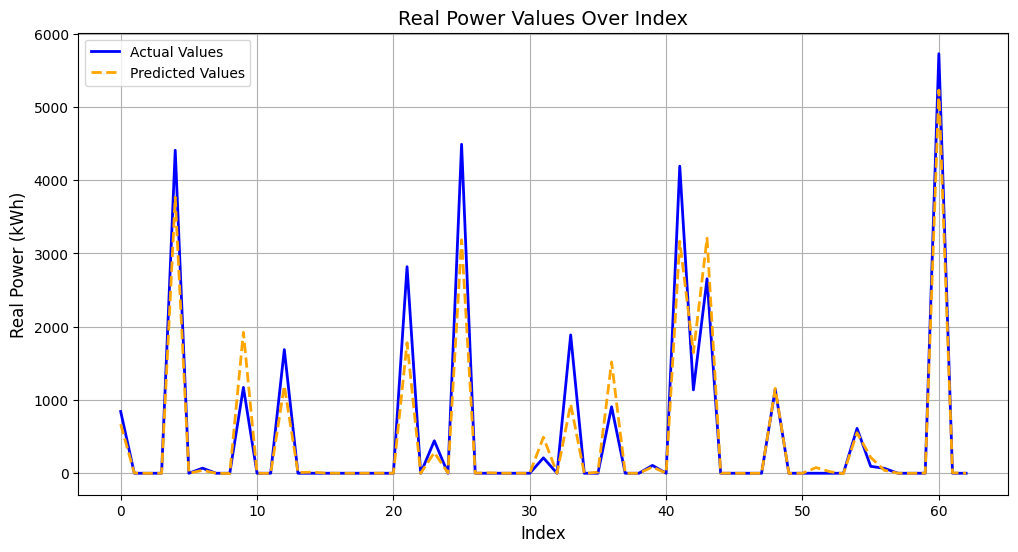

In [ ]:
# Generate indices for plotting (assuming y_test and y_pred are numpy arrays or lists)
indices = np.arange(len(y_test))  # Creates an index range from 0 to len(y_test)

# Plot actual vs predicted power values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(indices, y_test, label="Actual Values", color='blue', linewidth=2)

# Plot predicted values
plt.plot(indices, y_pred, label="Predicted Values", linestyle='dashed', color='orange', linewidth=2)

# Labels, title, and legend
plt.title('Real Power Values Over Index', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Real Power (kWh)', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Compute residuals
residuals = y_test - y_pred

# Print basic stats
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")

Mean Residual: 54.4030
Standard Deviation of Residuals: 335.9740


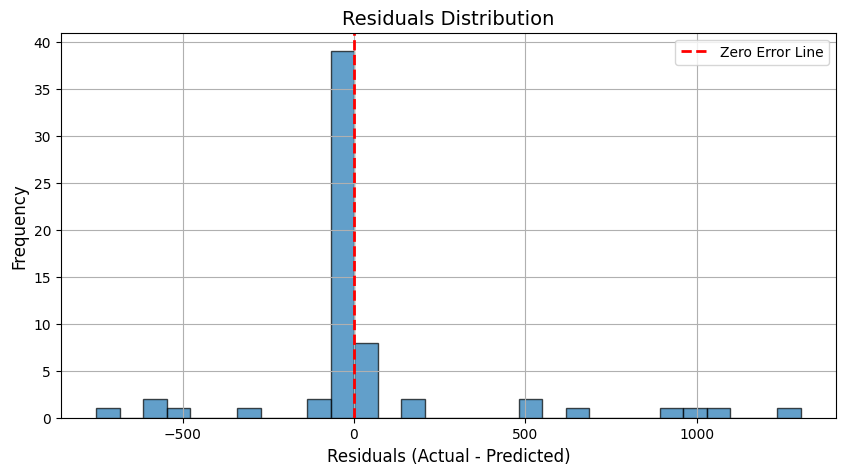

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2, label="Zero Error Line")

# Labels and title
plt.title('Residuals Distribution', fontsize=14)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


1.   The model underpredicts the actual power output by about 54.4 kWh.
2.   335.97 kWh is relatively large, it indicates that some predictions have significant deviations from actual values.


In [ ]:
# Save model
joblib.dump(final_model, "/content/drive/MyDrive/ENGN/Winter25/Design/trained_models/fine_tuned_xgboost.pkl")

['/content/drive/MyDrive/ENGN/Winter25/Design/trained_models/fine_tuned_xgboost.pkl']

In [ ]:
# Load model
loaded_model = joblib.load("/content/drive/MyDrive/ENGN/Winter25/Design/trained_models/fine_tuned_xgboost.pkl")
loaded_model

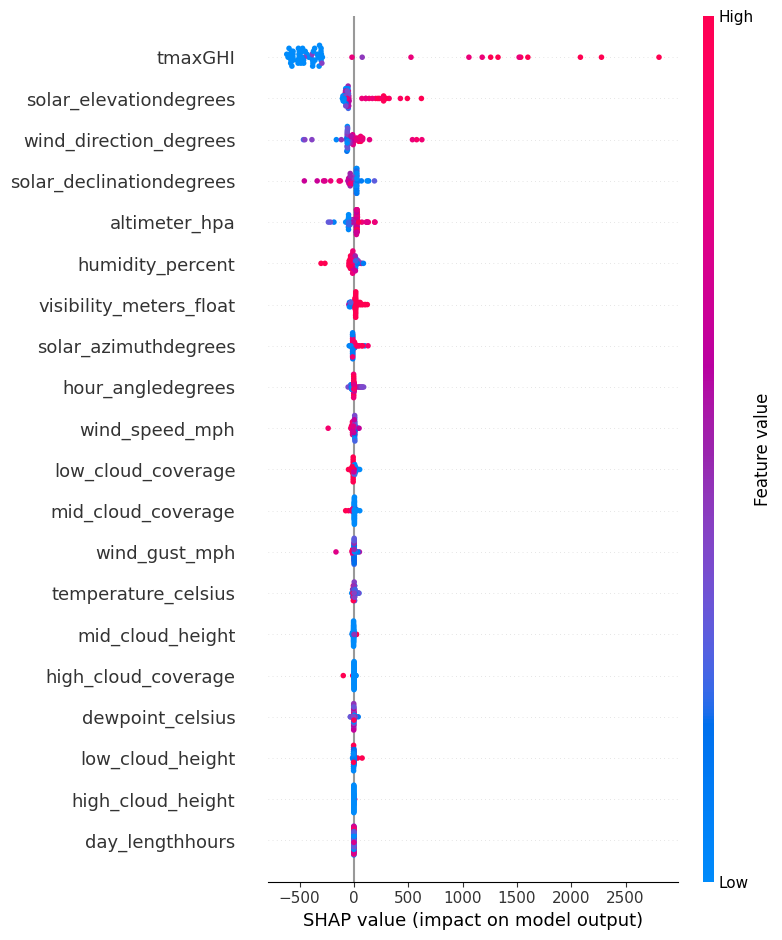

In [33]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)